In [1]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
np.random.seed(0)

# Dataset

In [2]:
n_tasks = 1
n_samples = 1000
n_features = 2

datasets = []
for i in range(n_tasks):
    mean1 = np.random.randn(2)
    mean2 = np.random.randn(2)
    cov = np.random.randn(2, 2)
    X1 = np.random.multivariate_normal(mean1, cov.T @ cov, n_samples)
    X2 = np.random.multivariate_normal(mean2, cov.T @ cov, n_samples)
    
    # Combine the data and create labels
    X = np.vstack((X1, X2))
    y = np.hstack((np.zeros(n_samples), np.ones(n_samples)))
    dataset = np.hstack((X, y.reshape(len(y), 1)))
    np.random.shuffle(dataset)
    n = len(dataset)
    dtrain = dataset[: int(0.8 * n)]
    dvalid = dataset[: int(0.2 * n)]
    datasets.append((dtrain, dvalid))

# Operations

In [3]:
def identity_func(x: object):
    return x

# func_indices = [0, 1, 2, 3]
functions = [identity_func, np.add, np.abs, np.matmul]

# Pool of variables 

In [4]:
class Pool:
    def __init__(self, num_of_scalars : int, num_of_vectors : int): # для простоты только векторы и скаляры
        self.num_of_scalars = num_of_scalars
        self.num_of_vectors = num_of_vectors
        self.scalars = np.zeros(num_of_scalars)
        self.vectors = np.zeros(shape=(num_of_vectors, n_features))
            
    def set_scalar(self, index: int, value: int):
        self.scalars[index] = value 
        
    def set_scalars(self, values: np.array):
        assert values.shape == self.scalars.shape
        self.scalars = values.copy()
        # np.copyto(self.scalars, values)
        
    def set_vector(self, index: int, value: np.array):
        self.vectors[index] = value.copy()
        # np.copyto(self.vectors[index], value)
        
    def set_vectors(self, values: np.array):
        assert values.shape == self.vectors.shape
        self.vectors = values.copy()
        # np.copyto(self.vectors, values)
        
    def get_scalar(self, index: int):
        return self.scalars[index]
    
    def get_scalars(self, indices: list = None):
        if indices is None:
            return self.scalars
        return self.scalars[indices]
    
    def get_vector(self, index: int):
        return self.vectors[index]
    
    def get_vectors(self, indices: list = None):
        if indices is None:
            return self.vectors 
        return self.vectors[indices]

    def __repr__(self):
        return f"Pool(\nscalars={self.scalars}, \nvectors=\n{self.vectors}\n)"

# Functions

## Abstract Function

In [5]:
class Function(ABC):
    @abstractmethod
    def eval_func(self):
        pass
    
    @abstractmethod
    def add_function(self, new_func):
        pass 
    
    @abstractmethod
    def remove_function(self, func_index: int):
        pass 
    
    @abstractmethod
    def replace_function(self, func_index: int):
        pass 
    
    @abstractmethod
    def change_inner_params(self, func_index: int):
        pass 

## Setup

In [6]:
class Setup(Function, ABC):
    def __init__(self):
        self.functions = [0.0] # dump values
        self._scalars = np.zeros(num_of_scalars)
        self._vectors = np.zeros(shape=(num_of_vectors, n_features))
    
    def replace_function(self, func_index: int):
        # self.change_inner_params(-1)
        pass 
    
    def add_function(self, new_func):
        # self.change_inner_params(-1)
        pass
    
    def remove_function(self, func_index: int):
        # self.change_inner_params(-1)
        pass 
        
    def change_inner_params(self, func_index: int):
        for i in range(num_of_scalars):
            self._scalars[i] = np.random.uniform(low=-20.0, high = 20.0)
        for i in range(num_of_vectors):
            for j in range(n_features):
                self._vectors[i][j] = np.random.uniform(low=-20.0, high = 20.0)
    
    def eval_func(self):
        pool.set_scalars(self._scalars)
        # print(self._vectors[0].shape)
        pool.set_vectors(self._vectors)
    

## Learn

In [7]:
class Learn(Function, ABC):
    def __init__(self):
        self.functions = [] # list of functions
        self.func_args = [] # list of tuples (var_type, [memory_indices])
        
    def add_function(self, func_type):
        self.functions.append(func_type)
        var_type = -1
        return_type = -1
        arg_indices = []
        return_index = -1
        if func_type == 0: 
            var_type = np.random.choice([0, 1]) # 0 - scalar, 1 - vector
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=1)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)
        elif func_type == 1:
            var_type = np.random.choice([0, 1])
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=2)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)
        elif func_type == 2: 
            var_type = np.random.choice([0, 1])
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=1)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)
        elif func_type == 3: 
            var_type = 1
            return_type = 0
            arg_indices = np.random.choice(np.arange(num_of_vectors), size=2)
            return_index = np.random.choice(np.arange(num_of_scalars), size=1)
            
        self.func_args.append(dict(
            var_type=var_type, 
            return_type=return_type,
            arg_indices=arg_indices,
            return_index=return_index
            )
        )
        
    def change_inner_params(self, func_index: int):
        func_type = self.functions[func_index]
        var_type = self.func_args[func_index]["var_type"]
        return_type = self.func_args[func_index]["return_type"]
        arg_size = None
        
        if func_type == 0:
            arg_size = 1
        elif func_type == 1:
            arg_size = 2
        elif func_type == 2:
            arg_size = 1
        elif func_type == 3:
            arg_size = 2
            
        self.func_args[func_index]["arg_indices"] = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=arg_size)
        self.func_args[func_index]["return_index"] = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors), size=1)


    
    def remove_function(self, func_index: int):
        del self.func_args[func_index]
        del self.functions[func_index]

    def replace_function(self, func_index: int):
        func_type = np.random.choice([0, 1, 2, 3])
        var_type = -1
        return_type = -1
        arg_indices = []
        return_index = -1
        if func_type == 0:
            var_type = np.random.choice([0, 1]) # 0 - scalar, 1 - vector
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=1)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors)[1:], size=1)
        elif func_type == 1:
            var_type = np.random.choice([0, 1])
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=2)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors)[1:], size=1)
        elif func_type == 2:
            var_type = np.random.choice([0, 1])
            return_type = var_type
            arg_indices = np.random.choice(np.arange(num_of_scalars if var_type == 0 else num_of_vectors), size=1)
            return_index = np.random.choice(np.arange(num_of_scalars if return_type == 0 else num_of_vectors)[1:], size=1)
        elif func_type == 3:
            var_type = 1
            return_type = 0
            arg_indices = np.random.choice(np.arange(num_of_vectors), size=2)
            return_index = np.random.choice(np.arange(num_of_scalars)[1:], size=1)
            
        self.functions[func_index] = func_type
        self.func_args[func_index] = dict(
            var_type=var_type, 
            return_type=return_type,
            arg_indices=arg_indices,
            return_index=return_index
        )

    def eval_func(self):
        for func_index, args in zip(self.functions, self.func_args):
            var_type = args["var_type"]
            return_type = args["return_type"]
            arg_indices = args["arg_indices"]
            return_index = args["return_index"]
            
            result = None
            if var_type == 0:
                result = functions[func_index](*pool.get_scalars(arg_indices))
            elif var_type == 1:
                result = functions[func_index](*pool.get_vectors(arg_indices))
                
            if return_type == 0:
                pool.set_scalar(index=return_index, value=result)
            elif return_type == 1:
                pool.set_vector(index=return_index, value=result)
            

## Predict

In [8]:
class Predict(Learn, ABC):
    pass

# Mutator

In [9]:
class Mutator:
    def __init__(self):
        self.mutate_types = [
            "add_function", 
            "remove_function", 
            "change_function", 
            "change_inner_params"
        ]
        self._critical_func_nums = 3
        
        
    def mutate(self, function: Function):
        mutation_type = np.random.choice(self.mutate_types)
        # mutation_type = "change_function"
        if not function.functions:
            mutation_type = "add_function"
            
        if len(function.functions) >= self._critical_func_nums:
            mutation_type = np.random.choice(self.mutate_types[1:])
            
        if mutation_type == "add_function":
            function_index = np.random.choice([0, 1, 2, 3])
            function.add_function(function_index)
        elif mutation_type == "remove_function":
            if len(function.functions) > 0:
                function.remove_function(np.random.choice(np.arange(len(function.functions))))
        elif mutation_type == "change_function":
            if len(function.functions) > 0:
                function.replace_function(np.random.choice(np.arange(len(function.functions))))
        elif mutation_type == "change_inner_params":
            if len(function.functions) > 0:
                function.change_inner_params(np.random.choice(np.arange(len(function.functions))))
            
        return function
            

# Evaluate function

In [10]:
def initialize_memory():
    pool.set_scalars(np.zeros(num_of_scalars))
    pool.set_vectors(np.zeros((num_of_vectors, n_features)))
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def normalize(x):
    return sigmoid(x)

def loss(true, predicted):
    # return -(true * np.log(predicted) + (1 - true) * np.log(1 - predicted))
    return np.abs(predicted - true)
    
def evaluate_one_task(setup: Setup, predict: Predict, learn: Learn, dtrain, dvalid):
    initialize_memory()
    setup.eval_func()
    for row in dtrain:
        x = row[:-1]
        y = row[-1]
        
        pool.set_vector(index=0, value=x) # v0 = x
        predict.eval_func()
        
        s1 = pool.get_scalar(index=1) # s1 = predict
        s1 = normalize(s1)
        pool.set_scalar(index=1, value=s1)
        pool.set_scalar(index=0, value=y) # s0 = true_label
        learn.eval_func()
    
    sum_loss = 0.0
    for row in dvalid:
        x = row[:-1]
        y = row[-1]
        
        pool.set_vector(index=0, value=x)
        predict.eval_func()
        s1 = pool.get_scalar(index=1)
        s1 = normalize(s1)
        
        sum_loss += loss(y, s1)
        
    mean_loss = sum_loss / len(dvalid)
    if mean_loss > 1 or np.isnan(mean_loss):
        mean_loss = 1 
    return mean_loss

def evaluate(setup: Setup, predict: Predict, learn: Learn):
    mean_loss = 0.0
    for dtrain, dvalid in datasets:
        mean_loss += evaluate_one_task(setup, predict, learn, dtrain, dvalid)
    return mean_loss / n_tasks

def get_best_model(models):
    best_model = models[0]
    for i in range(len(models)):
        if models[i][-1] < best_model[-1]:
            best_model = models[i]
    return best_model

## Check for degenerate models

In [11]:
def is_current_model_degenerate():
    """
    checks pool to see whether calculations with current model(setup, predict, learn) 
    produce degenerate values
    """
    scalars = pool.get_scalars()
    vectors = pool.get_vectors().flatten()
    values = np.concatenate((scalars, vectors))
    for elem in values:
        if elem is np.nan or elem is np.inf or elem is -np.inf or elem > 1e5 or elem < -1e5:
            return True 
    return False

# Evolution function

In [12]:
from copy import deepcopy
def run_evolution(POPULATION_SIZE, SUBSET_SIZE, CYCLES_NUM):
    population = []
    history = []
    while len(population) < POPULATION_SIZE:
        setup = mutator.mutate(Setup())
        predict = mutator.mutate(Predict())
        learn = mutator.mutate(Learn())
        mean_loss = evaluate(setup, predict, learn)
        while is_current_model_degenerate():
            setup = mutator.mutate(Setup())
            predict = mutator.mutate(Predict())
            learn = mutator.mutate(Learn())
            mean_loss = evaluate(setup, predict, learn)

        population.append([setup, predict, learn, mean_loss])
        history.append([setup, predict, learn, mean_loss])

    while len(history) - POPULATION_SIZE < CYCLES_NUM:
        candidates = []
        while len(candidates) < SUBSET_SIZE:
            random_model = random.choice(population)
            candidates.append(random_model)
        best_model = get_best_model(candidates)
        child = deepcopy(best_model)

        child[0] = mutator.mutate(child[0]) # mutate setup
        child[1] = mutator.mutate(child[1]) # mutate predict
        child[2] = mutator.mutate(child[2]) # mutate learn
        child[3] = evaluate(child[0], child[1], child[2])
        if is_current_model_degenerate():
            child[0] = mutator.mutate(child[0]) # mutate setup
            child[1] = mutator.mutate(child[1]) # mutate predict
            child[2] = mutator.mutate(child[2]) # mutate learn
            child[3] = evaluate(child[0], child[1], child[2])

        population.pop(0)
        history.append(child)
        population.append(child)


    return history

In [13]:
# from copy import deepcopy
# def run_evolution(POPULATION_SIZE, SUBSET_SIZE, CYCLES_NUM, history ):
#     population = []
#     while len(population) < POPULATION_SIZE:
#         setup = mutator.mutate(Setup())
#         predict = mutator.mutate(Predict())
#         learn = mutator.mutate(Learn())
#         mean_loss = evaluate(setup, predict, learn)
#         while is_current_model_degenerate():
#             setup = mutator.mutate(Setup())
#             predict = mutator.mutate(Predict())
#             learn = mutator.mutate(Learn())
#             mean_loss = evaluate(setup, predict, learn)

#         population.append([setup, predict, learn, mean_loss])
#         history.append([setup, predict, learn, mean_loss])

#     for c in tqdm(range(CYCLES_NUM)):
#         population = sorted(population, key = lambda x: x[-1])[:SUBSET_SIZE]
#         old_pop = population[:]
#         for p in old_pop:
#             child = deepcopy(p)
#             child[0] = mutator.mutate(child[0]) # mutate setup
#             child[1] = mutator.mutate(child[1]) # mutate predict
#             child[2] = mutator.mutate(child[2]) # mutate learn
#             child[3] = evaluate(child[0], child[1], child[2])
#             if is_current_model_degenerate():
#                 child[0] = mutator.mutate(child[0]) # mutate setup
#                 child[1] = mutator.mutate(child[1]) # mutate predict
#                 child[2] = mutator.mutate(child[2]) # mutate learn
#                 child[3] = evaluate(child[0], child[1], child[2])

#             history.append(child)
#             population.append(child)
#     return history 


# Run

In [27]:
num_of_scalars = 4
num_of_vectors = 4
pool = Pool(num_of_scalars=num_of_scalars, num_of_vectors=num_of_vectors)

In [28]:
mutator = Mutator()

In [29]:
%%time
# history = []
# run_evolution(100, 30, 1000, history)
history = run_evolution(POPULATION_SIZE=100, SUBSET_SIZE=30, CYCLES_NUM=5000)

/tmp/ipykernel_97754/1221444319.py:111: RuntimeWarning: overflow encountered in add
  result = functions[func_index](*pool.get_vectors(arg_indices))
/tmp/ipykernel_97754/1221444319.py:109: RuntimeWarning: overflow encountered in add
  result = functions[func_index](*pool.get_scalars(arg_indices))
/tmp/ipykernel_97754/3257875434.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_97754/1221444319.py:111: RuntimeWarning: overflow encountered in matmul
  result = functions[func_index](*pool.get_vectors(arg_indices))
/tmp/ipykernel_97754/1221444319.py:111: RuntimeWarning: invalid value encountered in matmul
  result = functions[func_index](*pool.get_vectors(arg_indices))
/tmp/ipykernel_97754/1221444319.py:109: RuntimeWarning: invalid value encountered in add
  result = functions[func_index](*pool.get_scalars(arg_indices))


CPU times: user 4min 17s, sys: 98.1 ms, total: 4min 17s
Wall time: 4min 17s


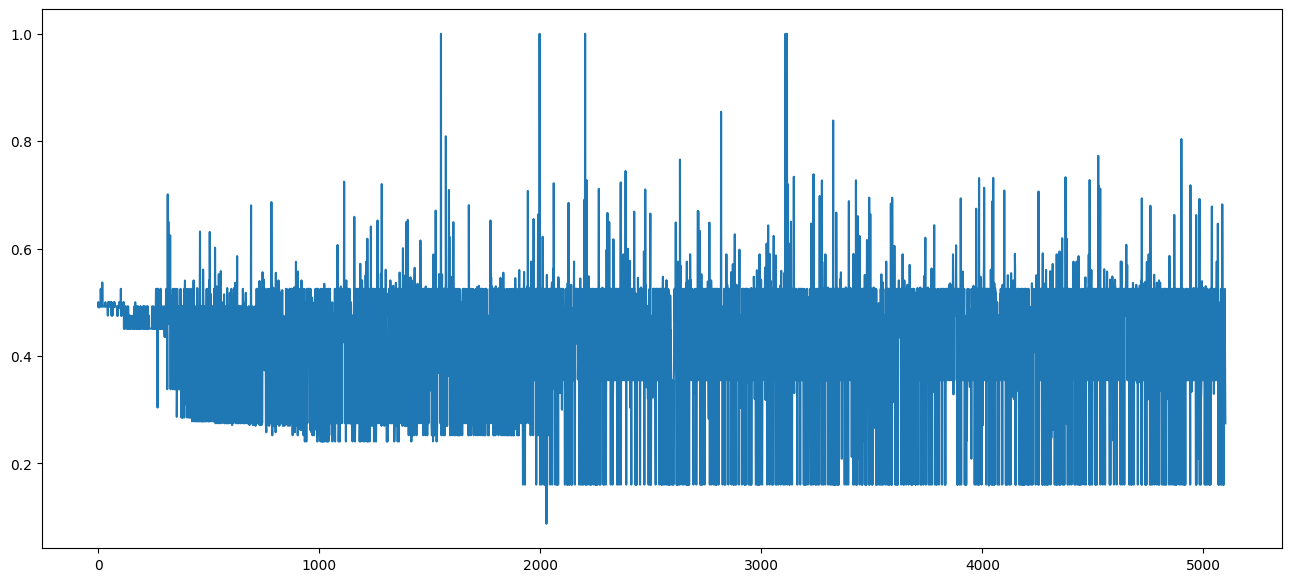

In [30]:
losses = []
for model in history:
    losses.append(model[-1])
plt.figure(figsize=(16, 7))
plt.plot(np.arange(len(losses)),losses);

In [31]:
print(pool)

Pool(
scalars=[ 0.00000000e+00  4.05381981e+00 -1.22051450e+04 -6.11012970e+00], 
vectors=
[[ 0.40010766  0.71823756]
 [19.47498552 -8.71918035]
 [ 0.40010766  0.71823756]
 [-1.17012253  6.29595982]]
)


In [32]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
train, valid = datasets[0]
model.fit(train[:,:-1], train[:,-1])
pred = model.predict(valid[:,:-1])
from sklearn.metrics import log_loss, accuracy_score
print("sklearn accuracy:",accuracy_score(valid[:, -1], pred))
print("sklearn log_loss:",log_loss(valid[:,-1], pred, labels=[0, 1]))
model.coef_, model.intercept_

sklearn accuracy: 0.99
sklearn log_loss: 0.36043653389117175


(array([[3.31162896, 7.74300643]]), array([-14.75586005]))

In [33]:
def get_prediction(setup: Setup, predict: Predict, learn: Learn, dvalid):
    initialize_memory()
    setup.eval_func()
    preds = []
    for row in dvalid:
        x = row[:-1]
        y = row[-1]
        pool.set_vector(index=0, value=x)
        predict.eval_func()
        s1 = pool.get_scalar(index=1)
        s1 = normalize(s1)
        pool.set_scalar(index=1, value=s1)
        preds.append((s1 >= 0.5))
    return preds    

best_model = history[-1]
for elem in history:
    # print(elem[-1], best_model[-1])
    if elem[-1] < best_model[-1]:
        best_model = elem 

In [34]:
preds = get_prediction(best_model[0], best_model[1], best_model[2], dvalid)

In [35]:
print("evolved model accuracy:", accuracy_score(valid[:,-1], preds))
print("evolved model absolute diff:", best_model[-1])

evolved model accuracy: 0.73
evolved model absolute diff: 0.0873685322070232


In [23]:
best_model[1].functions, best_model[1].func_args # predict 

([3],
 [{'var_type': 1,
   'return_type': 0,
   'arg_indices': array([2, 0]),
   'return_index': array([1])}])

In [24]:
best_model[2].functions, best_model[2].func_args # learn 

([1, 1],
 [{'var_type': 1,
   'return_type': 1,
   'arg_indices': array([3, 1]),
   'return_index': array([2])},
  {'var_type': 1,
   'return_type': 1,
   'arg_indices': array([0, 0]),
   'return_index': array([1])}])

In [25]:
best_model[0]._scalars

array([-3.64346567, -7.25886786,  9.24142445, -9.23343075])

In [26]:
best_model[0]._vectors

array([[ 14.81842956,  -8.24489856],
       [-17.94989746,  -1.18629497],
       [ -8.00378571,  -1.36184949],
       [ -8.3189421 ,  19.48058518]])

In [36]:
def f():
  pass 
type(f)

function